# TabNet

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df_clean = pd.read_csv("./data/pred_maintenance_cleaned.csv")

# Split features and target
X = df_clean.drop(columns=['Machine failure'])
y = df_clean['Machine failure']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Model training

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
import time

# Convert to numpy arrays (TabNet doesn't accept DataFrames)
# Ensure labels are numpy int arrays
# Convert X and y to correct format
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(int)
y_test_np = y_test.values.astype(int)


# Initialize model
tabnet_model = TabNetClassifier(seed=42)

# Train and time
start_time = time.time()
tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

training_time = time.time() - start_time

print(f"Training time: {training_time:.4f} seconds")


/Users/sherry/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67615 | val_accuracy: 0.945   |  0:00:00s
epoch 1  | loss: 0.19282 | val_accuracy: 0.966   |  0:00:00s
epoch 2  | loss: 0.11047 | val_accuracy: 0.966   |  0:00:00s
epoch 3  | loss: 0.08023 | val_accuracy: 0.966   |  0:00:00s
epoch 4  | loss: 0.06467 | val_accuracy: 0.966   |  0:00:01s
epoch 5  | loss: 0.04846 | val_accuracy: 0.8705  |  0:00:01s
epoch 6  | loss: 0.03679 | val_accuracy: 0.966   |  0:00:01s
epoch 7  | loss: 0.0296  | val_accuracy: 0.966   |  0:00:01s
epoch 8  | loss: 0.02794 | val_accuracy: 0.966   |  0:00:02s
epoch 9  | loss: 0.02546 | val_accuracy: 0.966   |  0:00:02s
epoch 10 | loss: 0.02303 | val_accuracy: 0.966   |  0:00:02s
epoch 11 | loss: 0.02305 | val_accuracy: 0.966   |  0:00:02s
epoch 12 | loss: 0.02004 | val_accuracy: 0.9725  |  0:00:02s
epoch 13 | loss: 0.01933 | val_accuracy: 0.972   |  0:00:03s
epoch 14 | loss: 0.01635 | val_accuracy: 0.971   |  0:00:03s
epoch 15 | loss: 0.01842 | val_accuracy: 0.9675  |  0:00:03s
epoch 16 | loss: 0.01274

/Users/sherry/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Predict and evaluate

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



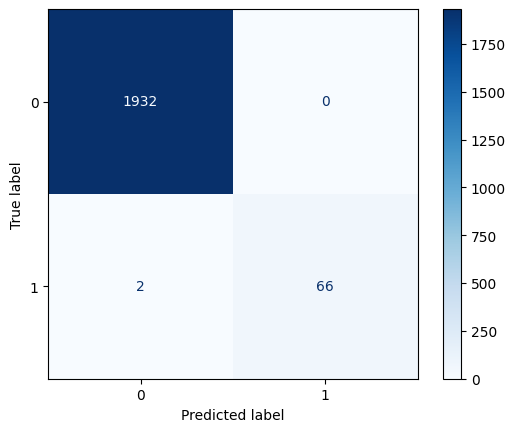

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = tabnet_model.predict(X_test_np)

# Evaluation metrics
report = classification_report(y_test_np, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test_np, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_np, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=tabnet_model.classes_)
disp.plot(cmap="Blues")


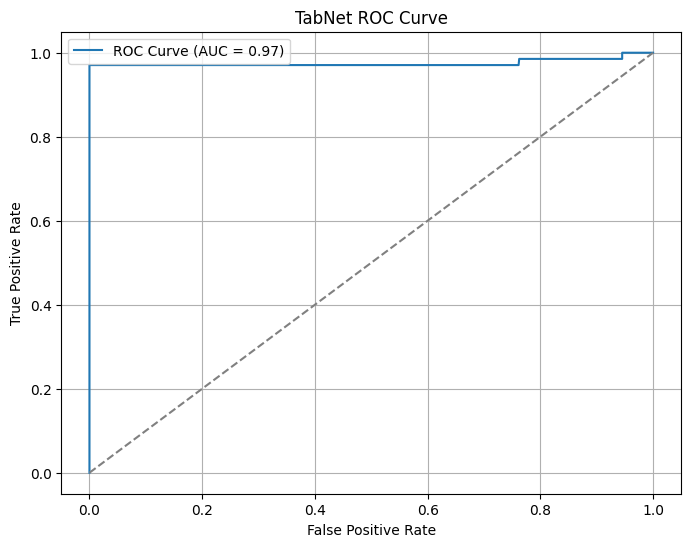

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for class 1
y_proba = tabnet_model.predict_proba(X_test_np)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_np, y_proba)
roc_auc = roc_auc_score(y_test_np, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TabNet ROC Curve")
plt.legend()
plt.grid()
plt.show()


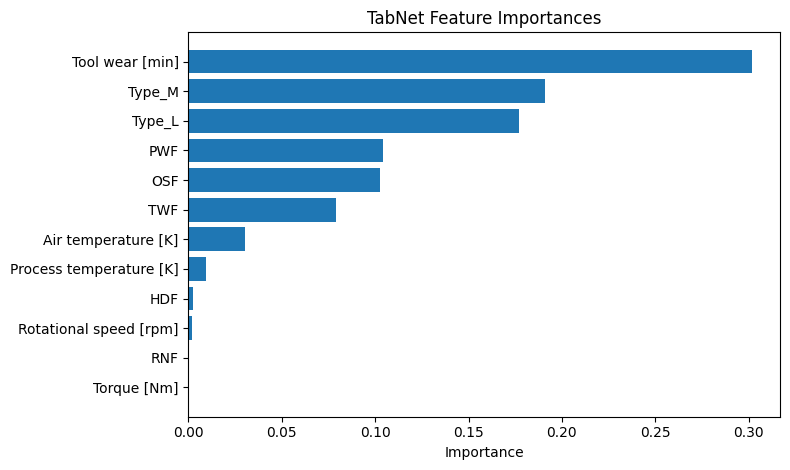

In [10]:
import numpy as np

# Get feature importances from TabNet
importances = tabnet_model.feature_importances_
feature_names = X.columns  # original column names

# Sort importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(8, len(feature_names) * 0.4))
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Importance")
plt.title("TabNet Feature Importances")
plt.tight_layout()
plt.show()


In [11]:
import csv

# Select key metrics from the report
metrics = {
    "Model": "TabNet",
    "Accuracy": report["accuracy"],
    "Precision": report["1"]["precision"],
    "Recall": report["1"]["recall"],
    "F1-score": report["1"]["f1-score"],
    "Training Time (s)": training_time
}

# Define output path
output_path = "./data/tabnet_metrics.csv"

# Save to CSV
with open(output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics saved to {output_path}")


Metrics saved to ./data/tabnet_metrics.csv
